# Venmo/Credit Card Fraud Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

file_path = 'venmo_transdata.csv'
df = pd.read_csv(file_path)

# Display the first few rows to verify the data has been loaded correctly
print(df.head())

   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0  


In [2]:
#getting simple statistics about the data we collected
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
# Before checking for the percentage we need to make sure there are no null values within the dataset
df.isnull().sum().max()

np.int64(0)

Not Frauds: 91.26 % of the dataset
Frauds: 8.74 % of the dataset


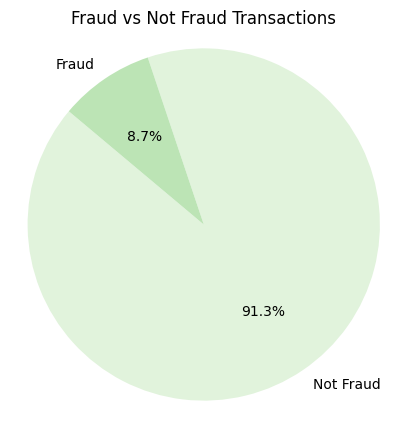

In [5]:
# here we can compare and visualize the difference in percentage of the split between frauds and valid transactions
# Calculate percentages assuming 'fraud' column exists
not_frauds_percent = round(df['fraud'].value_counts()[0] / len(df) * 100, 2)
frauds_percent = round(df['fraud'].value_counts()[1] / len(df) * 100, 2)

# Print percentages
print('Not Frauds:', not_frauds_percent, '% of the dataset')
print('Frauds:', frauds_percent, '% of the dataset')

fraud_counts = df['fraud'].value_counts()

# Map numeric labels to descriptive labels
fraud_counts.index = fraud_counts.index.map({0: 'Not Fraud', 1: 'Fraud'})

# Plotting a pie chart with elegant shades of blue
plt.figure(figsize=(5, 5))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens'))
plt.title('Fraud vs Not Fraud Transactions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [6]:
# Next we can drop duplicate values in case they exist, so we do not have skewed results

# mention the len of the df before and after
print("Count of data before removing duplicates:", len(df))
df = df.copy()

# Remove duplicates inplace
df.drop_duplicates(inplace=True)
print("Duplicates removed successfully.")

# Print the count of data after removing duplicates
print("Count of data after removing duplicates:", len(df))
print("In this case there is none")

Count of data before removing duplicates: 1000000
Duplicates removed successfully.
Count of data after removing duplicates: 1000000
In this case there is none


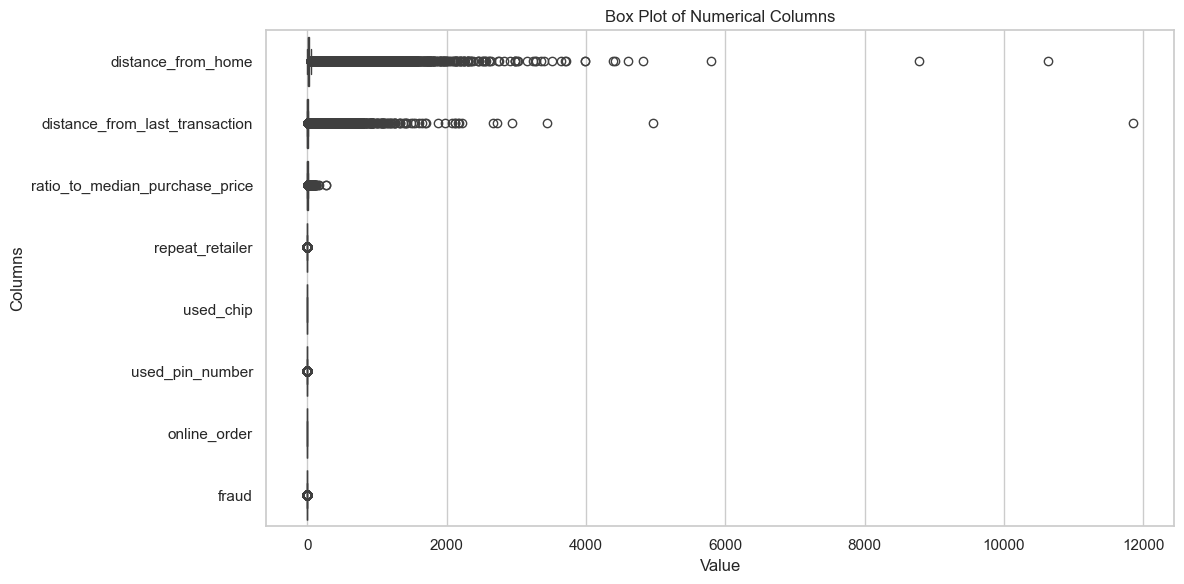

In [10]:
df = df.copy()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

sns.set(style="whitegrid", palette="Blues_r")
plt.figure(figsize=(12, 6))

sns.boxplot(data=df[numerical_columns], orient="h")
plt.title('Box Plot of Numerical Columns')
plt.xlabel('Value')
plt.ylabel('Columns')
plt.tight_layout()

# Show plot
plt.show()


In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


subset_set = df.sample(n=50000, random_state=36)

subset = subset_set.sample(n=25000, random_state=36)

# Specify predictors and outcome variable
predictors = ['distance_from_home', 'distance_from_last_transaction', 'online_order', 'ratio_to_median_purchase_price', 'repeat_retailer']
outcome = 'fraud'

# Extract predictors and outcome variable from the dataset
X = subset[predictors]
y = subset[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


model = MultinomialNB()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy_nb = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(accuracy_nb))

Accuracy: 0.913


In [25]:
new_data = {
    'distance_from_home': [10.5, 15.2, 8.0],
    'distance_from_last_transaction': [20.1, 25.0, 18.5],
    'online_order': [1, 0, 1],
    'ratio_to_median_purchase_price': [0.9, 1.2, 0.8],
    'repeat_retailer': [1, 0, 1]
}

# Create a DataFrame from the new input data
new_df = pd.DataFrame(new_data)

# Predict using the trained model
new_predictions = model.predict(new_df)

# Print the predictions
print("Predictions for new input data:")
for i, pred in enumerate(new_predictions):
    print(f"Input {i+1}: {'Fraud' if pred == 1 else 'Not Fraud'}")

Predictions for new input data:
Input 1: Not Fraud
Input 2: Not Fraud
Input 3: Not Fraud
